## From 
https://www.rasgoml.com/feature-engineering-tutorials/backward-stepwise-feature-selection-with-scikit-learn

In [2]:

import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
# import category_encoders as ce

from sklearn.ensemble import GradientBoostingRegressor


In [1]:
import dtale

In [10]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')


In [82]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic
import seaborn as sns
import matplotlib as plt
import pandas as pd
from datetime import datetime
import dtale
%matplotlib inline

### Predictors I should pick
1. Length of the orbit crossing the lake: orbit_leng
2. Area of the lake influence by the orbit: area_buffe
3. Lake area: Lake_area
4. Topography roughness: TRI_mdn
5. Variability of Lake surface water elevation (Option 1): APL
6. Variability of Lake surface water elevation (Option 2 flashiness index Baker 2004): rb_index
7. Variance of observations?? roughness. Standard deviation of the differences, based on https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r. I have std_diff and mean_diff. To calculate the variability it should be std_diff/abs(mean_diff) if mean diff!=0
8. Standard deviation of the observations std_obs
9. Probablility of ICE ??
##3 Reponse variables to try

In [68]:
#Bring the data 

path_win='/home/angelica/Dropbox/apps/python_pychm/locss/data/area_orbits_in_lakes/area_orbits_in_lakes_single.shp'


df_shp_lenghts=gpd.read_file(path_win)
df_shp_lenghts.head()
path_results='../data/results/comparison__20221114_13_16.csv'

# path_results='../data/results/comparison_ALL_20220906_16_59.csv'

df_results=pd.read_csv(path_results)
# print(df_results.head())
# df_shp_lenghts.head()
ic(df_results.columns)
ic(df_shp_lenghts.columns)

2022-11-14 16:37:16,020 - INFO     - Failed to auto identify EPSG: 7
ic| df_results.columns: Index(['Unnamed: 0', 'result_id', 'station', 'lake_name', 'altis',
                               'name_altis', 'source', 'method', 'R', 'PR_pvalue', 'RHO', 'RHO_pvalue',
                               'NSF', 'RMSE', 'APL', 'VE', 'cv_obs', 'std_obs', 'mean_obs', 'n_obs',
                               'rb_index', 'std_diff', 'mean_diff', 'sat_min_utcdate',
                               'sat_max_utcdate', 'grd_min_utcdate', 'grd_max_utcdate'],
                              dtype='object')
ic| df_shp_lenghts.columns: Index(['Slope_100', 'Lake_type', 'Lake_area', 'lake_name', 'Wshd_area',
                                   'Pour_long', 'source', 'Hylak_id', 'Computed', 'layer', 'Elevation',
                                   'orbit_leng', 'gauge_id', 'Pour_lat', 'area_buffe', 'Country',
                                   'new_area_l', 'USE', 'VS', 'geometry'],
                                  dt

Index(['Slope_100', 'Lake_type', 'Lake_area', 'lake_name', 'Wshd_area',
       'Pour_long', 'source', 'Hylak_id', 'Computed', 'layer', 'Elevation',
       'orbit_leng', 'gauge_id', 'Pour_lat', 'area_buffe', 'Country',
       'new_area_l', 'USE', 'VS', 'geometry'],
      dtype='object')

In [69]:
dtale.show(df_results)

In [70]:
#Results that won't be included in the selection 
df_results=df_results.loc[~df_results['result_id'].isin([1,6,8, 21])]
dtale.show(df_results)
# df_results[['station','name_altis','RHO']]

In [71]:

df_results['name_altis'] = df_results['name_altis'].apply(lambda x: x.strip())

df_merged=pd.merge(df_results,df_shp_lenghts, left_on='name_altis', right_on='VS', how='left')
# df_merged=df_merged.loc[df_merged['source_x']=='LOCSS']
# df_merged=df_merged.loc[~(df_merged['USE'].isnull())]
# df_merged=df_merged.loc[df_merged['USE']!='N']
df_merged.columns#shape
# df_merged.loc[df_merged['r2'].notna()]
# df_merged[['station','lake_name','orbit_leng','Lake_area', 'RHO', 'area_buffe']]
df_merged=df_merged.rename(columns={'lake_name_x':'lake_name'})
df_merged[['station','name_altis','VS','lake_name','lake_name_y','orbit_leng','Lake_area', 'RHO', 'area_buffe']].sort_values(by='station')

,station,name_altis,VS,lake_name,lake_name_y,orbit_leng,Lake_area,RHO,area_buffe
0,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0424,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.993,6.766995
1,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.967,6.766995
2,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.967,6.766995
3,12030,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,AlTiS_TimeSeries_Jason-3_GDR_F_0087_S0420,Açude Araras,Aï¿½ude Araras,3350.299028,67.41,0.967,6.766995
4,12030,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,Açude Araras,Aï¿½ude Araras,1442.903457,67.41,0.975,2.929606
5,12030,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,AlTiS_TimeSeries_Sentinel-3A_0104_S0424,Açude Araras,Aï¿½ude Araras,3055.960550,67.41,0.975,5.752967
6,12036,AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_016...,AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_016...,Açude Atalho,Aï¿½ude Atalho,527.182114,7.91,0.955,1.141536
7,12036,AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765,AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765,Açude Atalho,Atalho,495.253963,7.91,0.989,0.704895
8,12327,AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901,NaN,Açude Petrônio Portela,NaN,NaN,NaN,0.994,NaN
20,1824,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,AlTiS_TimeSeries_Sentinel-3A_0562_S4128,Lago Mascardi,Lago Mascardi,1010.538390,36.62,0.924,2.051678


In [72]:
df_merged.loc[df_merged['station']=='12036', ['result_id','RHO', 'altis', 'VS']].values
# AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765
# AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765

array([[5, 0.955,
        '12036_AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_0163_S0764',
        'AlTiS_TimeSeries_Jason-3_GDR_Ffrom2021Test_0163_S0764'],
       [7, 0.989, '12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765',
        'AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765']], dtype=object)

In [85]:
#fixing manually until I figure out why the merged is not working
df_merged.loc[df_merged['station']=='CFN2','orbit_leng' ]=0
# df_merged.loc[df_merged['station']=='CFN2','lake_name' ]='Catfish'
df_merged.loc[df_merged['station']=='CFN2','Lake_area' ]=3.72
df_merged.loc[df_merged['station']=='CFN2','area_buffe' ]=0

df_merged.loc[df_merged['station']=='YSL2','orbit_leng' ]=0
# df_merged.loc[df_merged['station']=='YSL2','lake_name' ]='Grays'
df_merged.loc[df_merged['station']=='YSL2','Lake_area' ]=0.27
df_merged.loc[df_merged['station']=='YSL2','area_buffe' ]=0

df_merged.loc[df_merged['station']=='MTN2','Lake_area' ]=159.97
df_merged.loc[df_merged['station']=='MTN2','area_buffe' ]=16.46
df_merged.loc[df_merged['station']=='MTN2','orbit_leng' ]=8332.24

df_merged.loc[df_merged['station']=='VCN2','Lake_area' ]=159.97
df_merged.loc[df_merged['station']=='VCN2','area_buffe' ]=16.46
df_merged.loc[df_merged['station']=='VCN2','orbit_leng' ]=8332.24

df_merged.loc[df_merged['station']=='BLB2','Lake_area' ]=7.4
df_merged.loc[df_merged['station']=='BLB2','area_buffe' ]=3.67
df_merged.loc[df_merged['station']=='BLB2','orbit_leng' ]=1778.06

df_merged.loc[df_merged['altis']=='2234_AlTiS_TimeSeries_Sentinel-3A_0676_S4325','Lake_area' ]=8.9
df_merged.loc[df_merged['altis']=='2234_AlTiS_TimeSeries_Sentinel-3A_0676_S4325','area_buffe' ]=1.178
df_merged.loc[df_merged['altis']=='2234_AlTiS_TimeSeries_Sentinel-3A_0676_S4325','orbit_leng' ]=639.37

df_merged.loc[df_merged['altis']=='12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901','Lake_area' ]=20.44
df_merged.loc[df_merged['altis']=='12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901','area_buffe' ]=1.21
df_merged.loc[df_merged['altis']=='12327_AlTiS_TimeSeries_Sentinel-3A_land_0760_S0901','orbit_leng' ]=626.28

#I don't get why this doesnt work
df_merged.loc[df_merged['altis']=='12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765','Lake_area' ]=7.91
df_merged.loc[df_merged['altis']=='12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765','area_buffe' ]=0.71
df_merged.loc[df_merged['altis']=='12036_AlTiS_TimeSeries_Sentinel-3B_land_0446_S0765','orbit_leng' ]=495.25

#The difference with name_altis and VS is the word new
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','Lake_area' ]=64.98
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','area_buffe' ]=3.95
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','orbit_leng' ]=4392.4

df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','Lake_area' ]=64.98
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','area_buffe' ]=3.95
df_merged.loc[df_merged['altis']=='19069_AlTiS_TimeSeries_Sentinel-3A_new_0190_S2751','orbit_leng' ]=4392.4


#Exclude RAW2
df_merged=df_merged.loc[df_merged['station']!='RAW2']
df_merged['per_area_c']=df_merged['area_buffe']/df_merged['Lake_area']

#Format all the names 
df_merged['lake_name']=df_merged['lake_name'].str.replace('Lake', '')
df_merged[['station','lake_name','orbit_leng','Lake_area', 'RHO', 'per_area_c', 'APL', 'mean_diff']]

,station,lake_name,orbit_leng,Lake_area,RHO,per_area_c,APL,mean_diff
0,12030,Açude Araras,3350.299028,67.41,0.993,0.100386,23.423,-0.078971
1,12030,Açude Araras,3350.299028,67.41,0.967,0.100386,19.044,0.037684
2,12030,Açude Araras,3350.299028,67.41,0.967,0.100386,19.044,0.037684
3,12030,Açude Araras,3350.299028,67.41,0.967,0.100386,19.044,0.037684
4,12030,Açude Araras,1442.903457,67.41,0.975,0.043460,16.456,0.000395
5,12030,Açude Araras,3055.960550,67.41,0.975,0.085343,16.456,0.000395
6,12036,Açude Atalho,527.182114,7.91,0.955,0.144316,13.516,-0.082857
7,12036,Açude Atalho,495.250000,7.91,0.989,0.089760,15.845,0.645556
8,12327,Açude Petrônio Portela,626.280000,20.44,0.994,0.059198,2.861,0.015000
9,BLB2,Balashur,1778.060000,7.40,0.607,0.495946,2.197,0.215000


In [74]:
cols=['Lake_area','lake_name','area_buffe','new_area_l','orbit_leng','station','altis','name_altis','rb_index', 'std_diff','mean_diff','std_obs','per_area_c','source_x','RHO', 'NSF','RMSE', 'APL', 'VE', 'n_obs']

df_t=pd.melt(df_merged[cols], id_vars=['Lake_area','lake_name','area_buffe','new_area_l','orbit_leng','station','altis','name_altis','rb_index', 'std_diff','std_obs','mean_diff','per_area_c','source_x','APL', 'VE', 'n_obs'], 
             value_vars=['RHO', 'NSF','RMSE'], ignore_index=True)
df_t['mission']=[x.split('_')[2] for x in df_t['altis']]

dtale.show(df_t)

In [75]:
#Load TRI 1 and 3 km
# df_stats_1km=pd.read_csv('../data/results/TRI_stats_1km.csv', sep=',')
df_stats_3km=pd.read_csv('../data/results/TRI_stats_3km_2.csv', sep=',')
df_t_3km=pd.merge(df_t, df_stats_3km, left_on='station', right_on='gauge_id', how='left')

In [76]:
df_t_3km=df_t_3km.rename(columns={'median':'TRI_mdn'})

In [114]:
df_t_3km.loc[df_t_3km['station']=='VCN2','TRI_mdn' ]=df_t_3km.loc[df_t_3km['station']=='MTN2','TRI_mdn' ].values[0]
df_t_3km.loc[df_t_3km['station']=='FDN2','TRI_mdn' ]=df_t_3km.loc[df_t_3km['station']=='PHN2','TRI_mdn' ].values[0]

In [115]:
df_t_3km.loc[df_t_3km['station'].isin(['VCN2', 'FDN2', 'MTN2', 'PHN2'])]

,Lake_area,lake_name,area_buffe,new_area_l,orbit_leng,station,altis,name_altis,rb_index,std_diff,...,value,mission,Unnamed: 0,gauge_id,TRI_mdn,mean,max,min,count,std
24,159.97,Mattamuskeet East,16.46000,NaN,8332.240000,VCN2,VCN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.089593,0.129741,...,0.609,TimeSeries,NaN,NaN,2.828427,NaN,NaN,NaN,NaN,NaN
25,159.97,Mattamuskeet West,16.46000,NaN,8332.240000,MTN2,MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.091578,0.120014,...,0.376,TimeSeries,24.0,MTN2,2.828427,2.761123,4.358899,1.0,205854.0,0.861623
26,63.07,Phelps,4.21484,63.071218,2651.700652,FDN2,FDN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.014337,0.031919,...,0.267,TimeSeries,NaN,NaN,2.449490,NaN,NaN,NaN,NaN,NaN
27,63.07,Phelps East,4.21484,63.071218,2651.700652,PHN2,PHN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.013364,0.125769,...,0.471,TimeSeries,26.0,PHN2,2.449490,2.562359,4.000000,1.0,130313.0,0.762211
67,159.97,Mattamuskeet East,16.46000,NaN,8332.240000,VCN2,VCN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.089593,0.129741,...,0.447,TimeSeries,NaN,NaN,2.828427,NaN,NaN,NaN,NaN,NaN
68,159.97,Mattamuskeet West,16.46000,NaN,8332.240000,MTN2,MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.091578,0.120014,...,-0.005,TimeSeries,24.0,MTN2,2.828427,2.761123,4.358899,1.0,205854.0,0.861623
69,63.07,Phelps,4.21484,63.071218,2651.700652,FDN2,FDN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.014337,0.031919,...,-0.089,TimeSeries,NaN,NaN,2.449490,NaN,NaN,NaN,NaN,NaN
70,63.07,Phelps East,4.21484,63.071218,2651.700652,PHN2,PHN2_AlTiS_TimeSeries_Sentinel-3A_0149_N3577,AlTiS_TimeSeries_Sentinel-3A_0149_N3577,0.013364,0.125769,...,-0.407,TimeSeries,26.0,PHN2,2.449490,2.562359,4.000000,1.0,130313.0,0.762211
110,159.97,Mattamuskeet East,16.46000,NaN,8332.240000,VCN2,VCN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.089593,0.129741,...,0.108,TimeSeries,NaN,NaN,2.828427,NaN,NaN,NaN,NaN,NaN
111,159.97,Mattamuskeet West,16.46000,NaN,8332.240000,MTN2,MTN2_AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,AlTiS_TimeSeries_Sentinel-3B_land_0022_N3549,0.091578,0.120014,...,0.127,TimeSeries,24.0,MTN2,2.828427,2.761123,4.358899,1.0,205854.0,0.861623


In [116]:
df_t_3km_vars=df_t_3km.loc[df_t_3km['variable']=='RHO']

predictors=['Lake_area','orbit_leng', 'area_buffe','per_area_c','TRI_mdn','APL', 'n_obs', 'rb_index', 'std_diff','mean_diff', 'std_obs']
df_predictors=df_t_3km_vars[predictors].copy()
outcome=df_t_3km_vars['value'].to_numpy().copy()

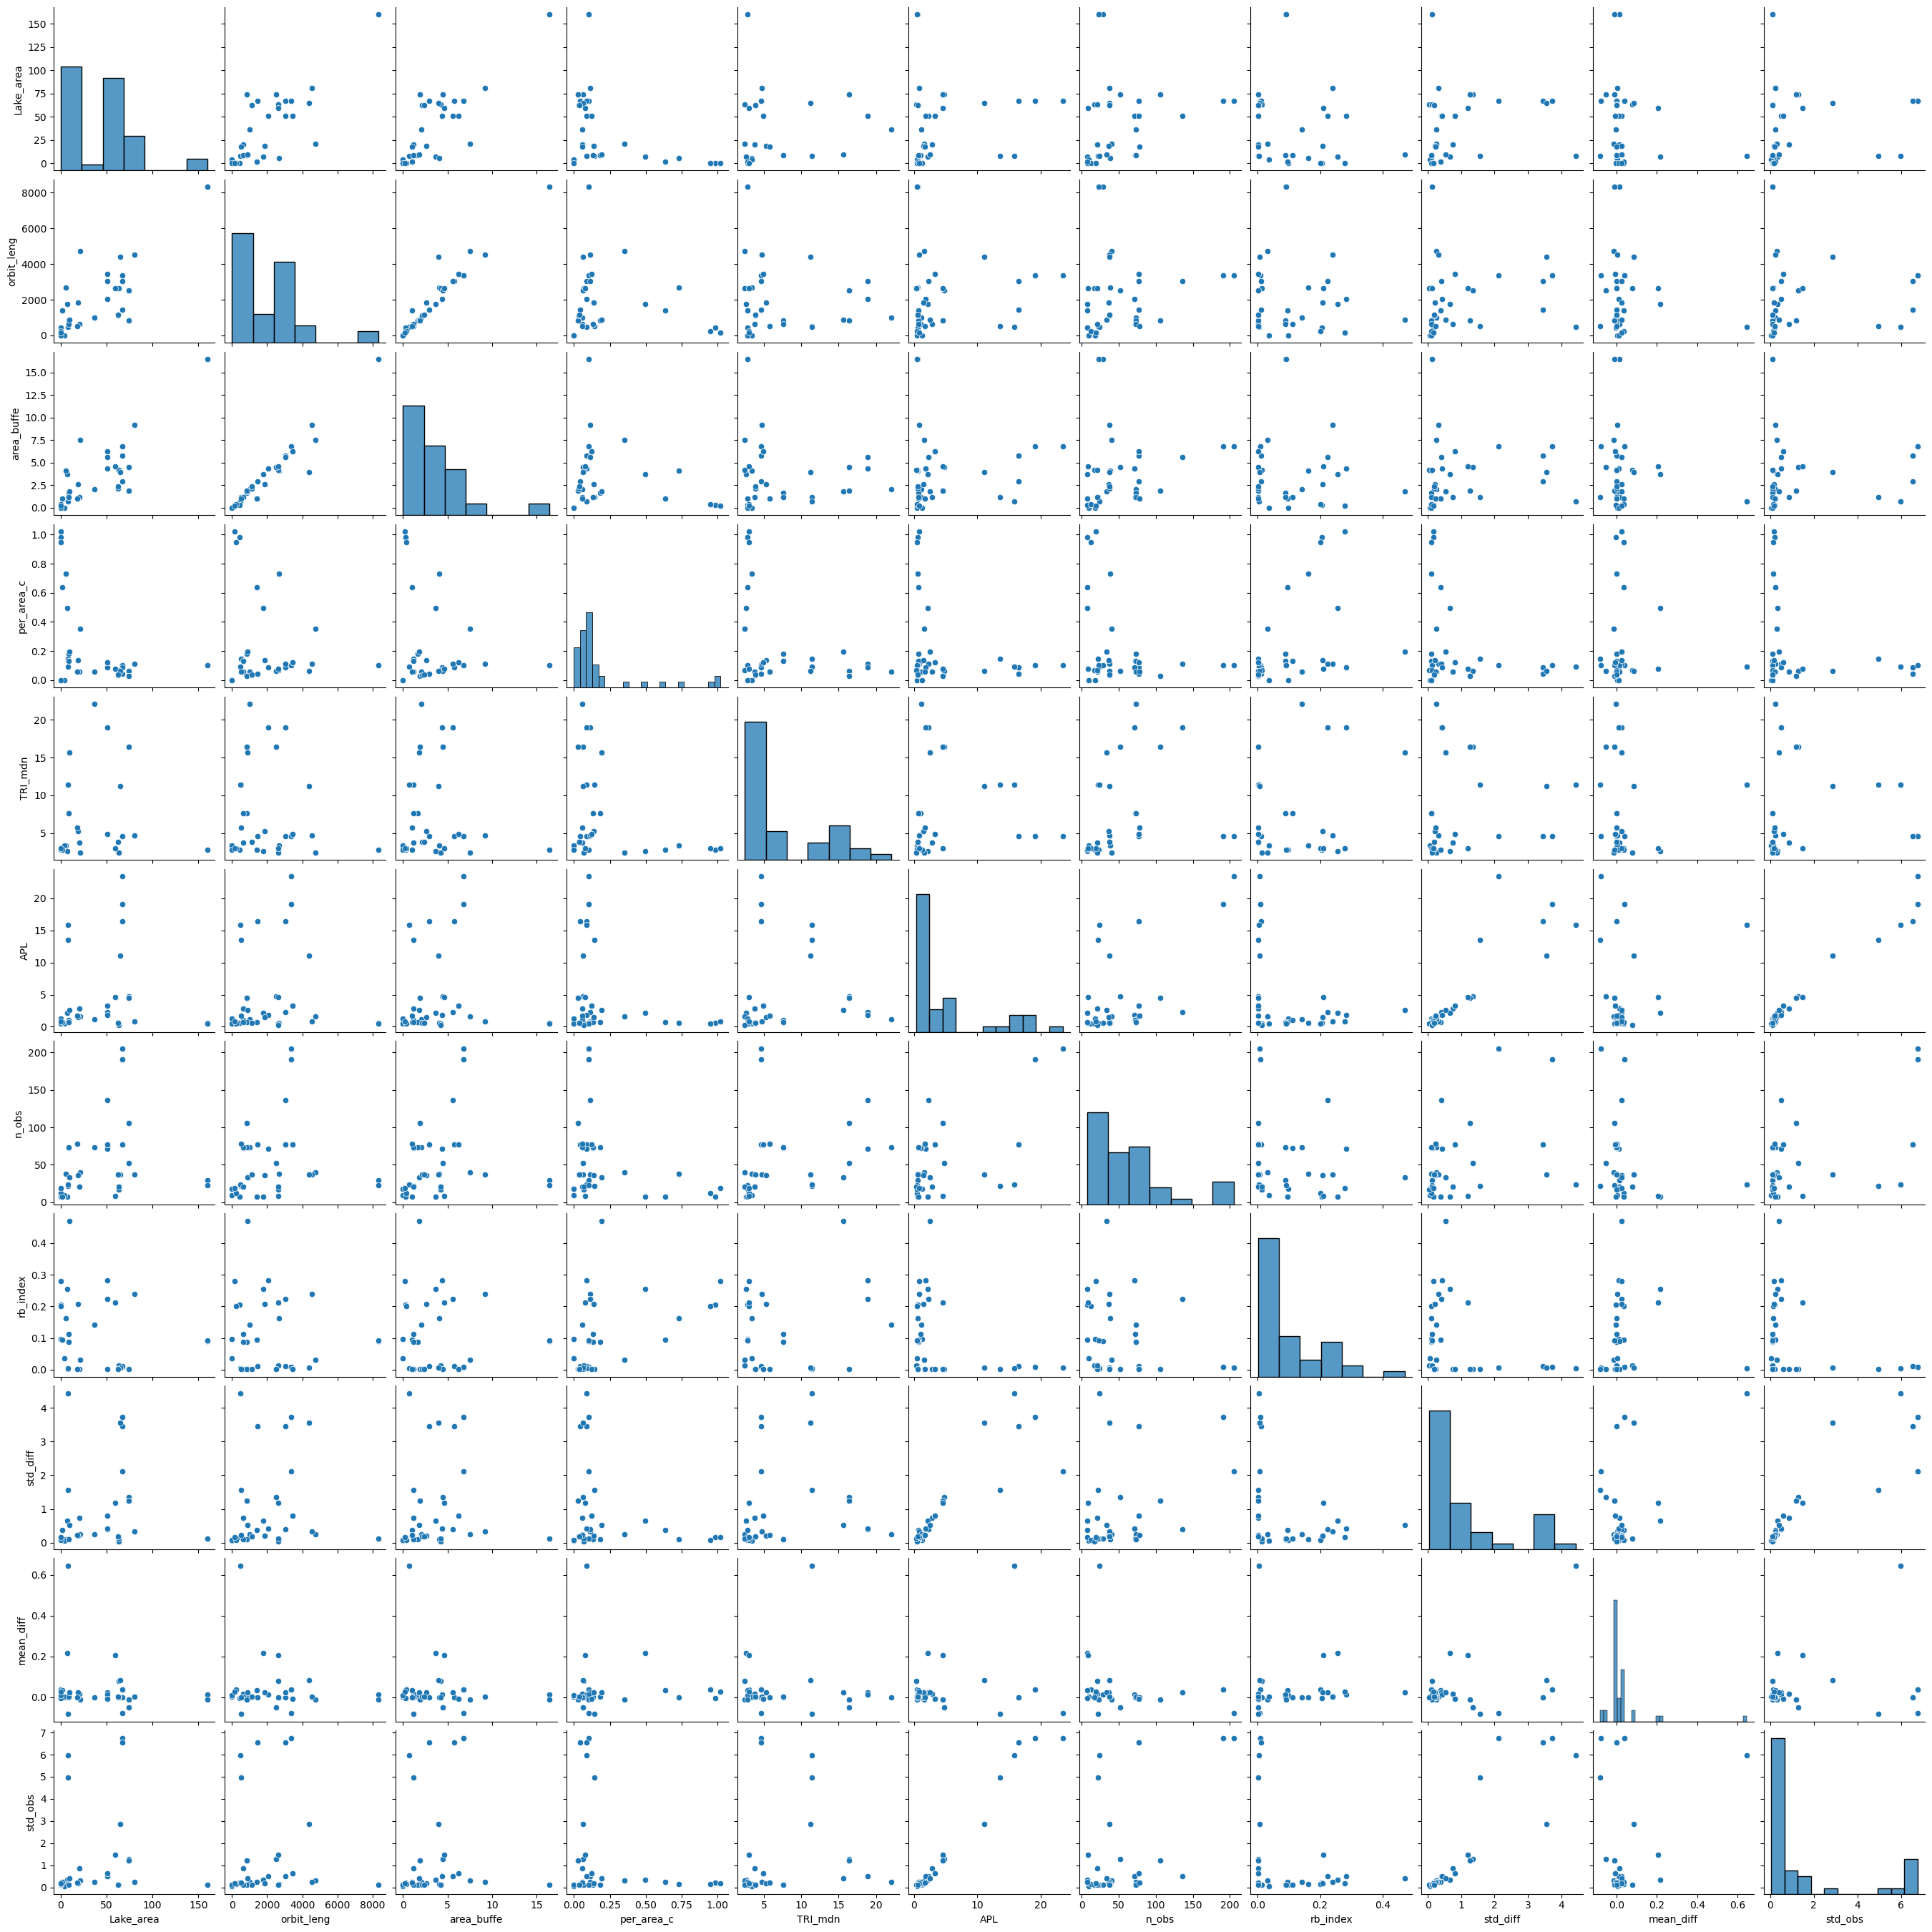

In [83]:
import seaborn as sns
sns.pairplot(df_predictors)


In [98]:
df_t_3km[predictors+['value', 'station']]


In [117]:
#correlation matrix
corr=df_t_3km_vars[predictors+['value']].corr()
corr.style.background_gradient(cmap='coolwarm')
# https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea

,Lake_area,orbit_leng,area_buffe,per_area_c,TRI_mdn,APL,n_obs,rb_index,std_diff,mean_diff,std_obs,value
Lake_area,1.000000,0.777949,0.816940,-0.467495,0.072184,0.183203,0.279501,-0.304935,0.203017,-0.179593,0.174345,0.095077
orbit_leng,0.777949,1.000000,0.973668,-0.182052,-0.199756,0.115418,0.141853,-0.093458,0.111799,-0.100128,0.098050,-0.010066
area_buffe,0.816940,0.973668,1.000000,-0.218678,-0.181761,0.131922,0.208757,-0.070370,0.092594,-0.122760,0.123393,0.001538
per_area_c,-0.467495,-0.182052,-0.218678,1.000000,-0.319820,-0.249460,-0.321212,0.466011,-0.265400,0.022837,-0.228341,-0.219861
TRI_mdn,0.072184,-0.199756,-0.181761,-0.319820,1.000000,0.014714,0.233777,0.097006,0.096044,-0.038960,-0.016923,0.479265
APL,0.183203,0.115418,0.131922,-0.249460,0.014714,1.000000,0.663837,-0.390079,0.914498,0.169979,0.987965,0.535707
n_obs,0.279501,0.141853,0.208757,-0.321212,0.233777,0.663837,1.000000,-0.304826,0.527183,-0.204727,0.616564,0.478475
rb_index,-0.304935,-0.093458,-0.070370,0.466011,0.097006,-0.390079,-0.304826,1.000000,-0.397999,0.078554,-0.386346,-0.121950
std_diff,0.203017,0.111799,0.092594,-0.265400,0.096044,0.914498,0.527183,-0.397999,1.000000,0.376869,0.922860,0.565812
mean_diff,-0.179593,-0.100128,-0.122760,0.022837,-0.038960,0.169979,-0.204727,0.078554,0.376869,1.000000,0.201537,0.061921


In [152]:
new_predictors=['area_buffe', 'per_area_c','TRI_mdn', 'std_obs', 'value']
new_corr=df_t_3km_vars[new_predictors].corr()
new_corr.style.background_gradient(cmap='coolwarm')

,area_buffe,per_area_c,TRI_mdn,std_obs,value
area_buffe,1.000000,-0.218678,-0.181761,0.123393,0.001538
per_area_c,-0.218678,1.000000,-0.319820,-0.228341,-0.219861
TRI_mdn,-0.181761,-0.319820,1.000000,-0.016923,0.479265
std_obs,0.123393,-0.228341,-0.016923,1.000000,0.511688
value,0.001538,-0.219861,0.479265,0.511688,1.000000


Executing shutdown due to inactivity...


2022-11-15 10:06:28,412 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-11-15 10:06:28,465 - INFO     - Executing shutdown...


Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdown_server
    raise RuntimeError("Not 

2022-11-15 10:06:28,471 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdow

In [123]:
time_file=datetime.now().strftime("%Y%m%d_%H_%M")
df_t_3km_vars.to_csv('../data/results/to_importance_'+time_file+'.csv', sep=',')

Executing shutdown due to inactivity...


2022-11-14 17:38:16,200 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-11-14 17:38:16,234 - INFO     - Executing shutdown...


Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdown_server
    raise RuntimeError("Not 

2022-11-14 17:38:16,244 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdow

In [122]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = predictors
vif["vif_Factor"] = [variance_inflation_factor(df_t_3km_vars[predictors].values, i) for i in range(df_t_3km_vars[predictors].shape[1])]
vif.sort_values(by='vif_Factor')

,features,vif_Factor
3,per_area_c,2.201295
9,mean_diff,2.361480
7,rb_index,3.300468
4,TRI_mdn,4.354513
6,n_obs,7.346059
0,Lake_area,13.161548
8,std_diff,33.164356
1,orbit_leng,100.426068
5,APL,109.419974
2,area_buffe,122.388617


In [124]:
#From here
#https://xavierbourretsicotte.github.io/subset_selection.html

import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')


In [131]:
#Best subset selection 
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [135]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
df=df_t_3km_vars[new_predictors]
Y = df['value']
X = df.drop(columns = 'value', axis = 1)
k = 5
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df_out = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

/tmp/ipykernel_193273/4103741698.py:13: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Loop...:   0%|          | 0/5 [00:00<?, ?it/s]

In [140]:
df_min = df_out[df_out.groupby('numb_features')['RSS'].transform(min) == df_out['RSS']]
df_max = df_out[df_out.groupby('numb_features')['R_squared'].transform(max) == df_out['R_squared']]
display(df_min)
display(df_max)

,numb_features,RSS,R_squared,features
4,1,1.561421,0.261824,"(std_obs,)"
13,2,1.057701,0.499963,"(TRI_mdn, std_obs)"
22,3,1.050123,0.503545,"(per_area_c, TRI_mdn, std_obs)"
26,4,1.045817,0.505580,"(area_buffe, per_area_c, TRI_mdn, std_obs)"
30,5,1.044818,0.506053,"(area_buffe, per_area_c, TRI_mdn, mean_diff, s..."


,numb_features,RSS,R_squared,features
4,1,1.561421,0.261824,"(std_obs,)"
13,2,1.057701,0.499963,"(TRI_mdn, std_obs)"
22,3,1.050123,0.503545,"(per_area_c, TRI_mdn, std_obs)"
26,4,1.045817,0.505580,"(area_buffe, per_area_c, TRI_mdn, std_obs)"
30,5,1.044818,0.506053,"(area_buffe, per_area_c, TRI_mdn, mean_diff, s..."


In [143]:
display(df_out)

,numb_features,RSS,R_squared,features
0,1,2.115238,0.000002,"(area_buffe,)"
1,1,2.012994,0.048339,"(per_area_c,)"
2,1,1.629382,0.229695,"(TRI_mdn,)"
3,1,2.107133,0.003834,"(mean_diff,)"
4,1,1.561421,0.261824,"(std_obs,)"
5,2,2.008182,0.050614,"(area_buffe, per_area_c)"
6,2,1.612191,0.237822,"(area_buffe, TRI_mdn)"
7,2,2.106953,0.003919,"(area_buffe, mean_diff)"
8,2,1.553271,0.265677,"(area_buffe, std_obs)"
9,2,1.618937,0.234633,"(per_area_c, TRI_mdn)"


In [145]:
#Initialization variables
# Y = credit.Balance
# X = credit.drop(columns = 'Balance', axis = 1)
# k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()
df_out_sw = pd.DataFrame({'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

ValueError: All arrays must be of the same length

In [149]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], RSS_list[i]) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['std_obs'], 1.5614211796576123),
 (2, ['std_obs', 'TRI_mdn'], 1.0577008121677787),
 (3, ['std_obs', 'TRI_mdn', 'per_area_c'], 1.0501230580716743),
 (4, ['std_obs', 'TRI_mdn', 'per_area_c', 'area_buffe'], 1.045817452113053)]

In [ ]:
#best subset 
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

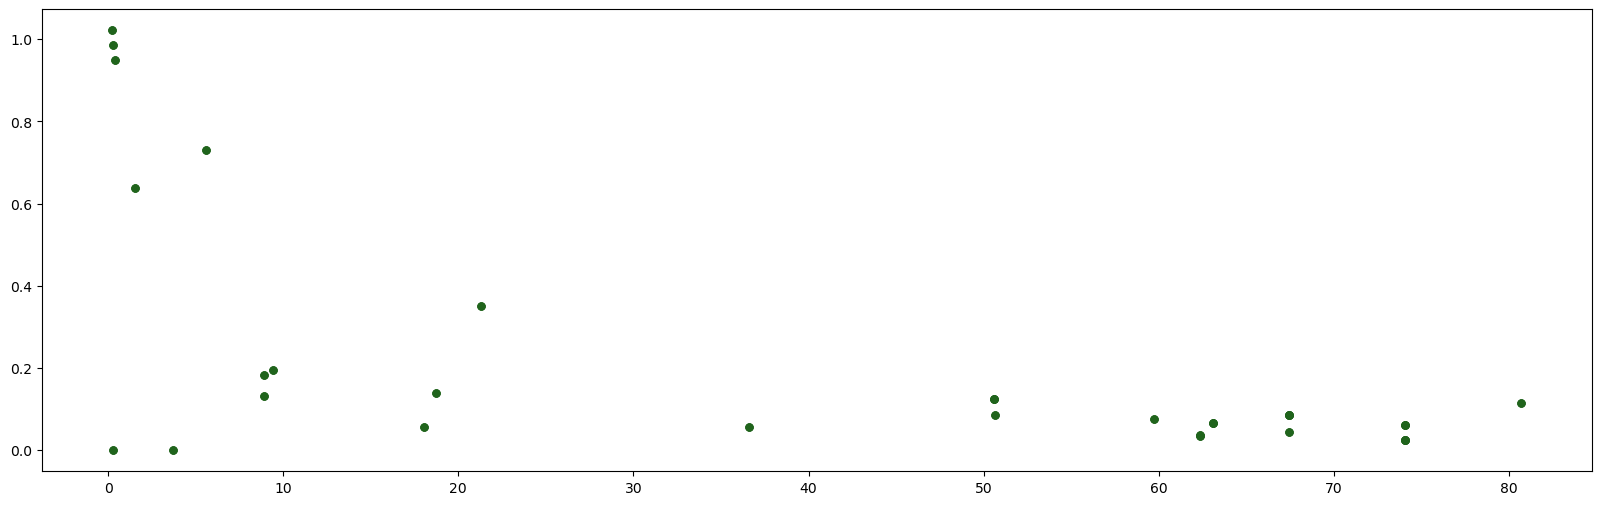

Executing shutdown due to inactivity...


2022-11-11 15:49:46,507 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-11-11 15:49:46,556 - INFO     - Executing shutdown...


Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdown_server
    raise RuntimeError("Not 

2022-11-11 15:49:46,559 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/flask/app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 435, in shutdown
    shutdown_server()
  File "/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/dtale/app.py", line 421, in shutdow

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(df_t_3km['Lake_area'], df_t_3km['per_area_c'],  linestyle='None',marker='o', markerfacecolor='#20641c',markeredgecolor='#20641c',markersize=5)

In [8]:
# Build step forward feature selection
sfs1 = SequentialFeatureSelector(clf,n_features_to_select='auto')

# Perform SFFS
sfs1 = sfs1.fit(X, y)

In [9]:
sfs1

SequentialFeatureSelector(estimator=LinearRegression(),
                          n_features_to_select='auto')